Make sure the tf version is 2.5.0-dev20201111 or later (for model saving)

In [1]:
#!pip install tf-nightly -qqq --progress-bar off
import tensorflow as tf
print(tf.__version__)
#assert tf.__version__== '2.5.0-dev20201111','bad version'

2.5.0-dev20201111


In [2]:
tf.test.gpu_device_name()

''

In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
!nvidia-smi -L

In [ ]:
from datetime import datetime;now = datetime.now;t00 = now()
print(t00)

In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# import timeit

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

# def cpu():
#   with tf.device('/cpu:0'):
#     random_image_cpu = tf.random.normal((100, 100, 100, 3))
#     net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
#     return tf.math.reduce_sum(net_cpu)

# def gpu():
#   with tf.device('/device:GPU:0'):
#     random_image_gpu = tf.random.normal((100, 100, 100, 3))
#     net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
#     return tf.math.reduce_sum(net_gpu)
  
# # We run each op once to warm up; see: https://stackoverflow.com/a/45067900
# cpu()
# gpu()

# # Run the op several times.
# print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
#       '(batch x height x width x channel). Sum of ten runs.')
# print('CPU (s):')
# cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
# print(cpu_time)
# print('GPU (s):')
# gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")
# print('done, mounted')

In [ ]:
# cd '/content/drive/My Drive/BC-MRI-AE/Colab Notebooks'

In [18]:
%matplotlib inline

import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

#from contrastive_vae.celeb_utils import get_celeb_vae
#from contrastive_vae.celeb_utils import get_celeb_cvae

import pandas as pd
from sklearn.metrics import silhouette_score

from mri_utils2 import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

print(now()-t00)

0:00:52.405759


In [ ]:
cd ../

SHAPE THE DATA

In [ ]:
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

In [ ]:
aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

In [ ]:
df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=0)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

In [ ]:
TD_subs = ABIDE_data[np.array(df['Subject Type']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['Subject Type']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

In [ ]:
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2

# TRAIN THE VAE

In [16]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def plot_recon_vae():
    plt.figure(figsize=(5,5));
    plt.subplot(2,2,1)
    plt.imshow(DX_batch[0,:,:,40]);plt.xticks([]);plt.yticks([]);plt.title('input');
    plt.subplot(2,2,2)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[0][0,:,:,40,0]);plt.xticks([]);plt.yticks([]);plt.title('reconstruction');

    plt.subplot(2,2,3)
    plt.imshow(TD_batch[0,32,:,:]);plt.xticks([]);plt.yticks([]);
    plt.subplot(2,2,4)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[1][0,32,:,:,0]);plt.xticks([]);plt.yticks([]);

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import silhouette_score
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import os
import pandas as pd
from glob import glob
#import helper

In [21]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



In [22]:
def get_MRI_CVAE_3D(input_shape=(64,64,64,1), latent_dim=2, batch_size = 32, disentangle=False, gamma=1):
    #TODO: add discriminator loss, see if there is improvement. Perhaps try on shapes dataset if it's easier...

    image_size, _, _, channels = input_shape
    kernel_size = 3
    filters = 16
    intermediate_dim = 128
    epochs = 10
    nlayers = 2
    
    # VAE model = encoder + decoder
    # build encoder model
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    for i in range(nlayers):
        filters *= 2
        x = Conv3D(filters=filters,
                   kernel_size=kernel_size,
                   activation='relu',
                   strides=2,
                   padding='same')(x)

    # shape info needed to build decoder model
    shape = K.int_shape(x)

    # generate latent vector Q(z|X)
    x = Flatten()(x)
    x = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    x = Dense(shape[1] * shape[2] * shape[3] * shape[4], activation='relu')(x)
    x = Reshape((shape[1], shape[2], shape[3],shape[4]))(x)

    for i in range(nlayers):
        x = Conv3DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            activation='relu',
                            strides=2,
                            padding='same')(x)
        filters //= 2

    outputs = Conv3DTranspose(filters=1,
                              kernel_size=kernel_size,
                              activation='sigmoid',
                              padding='same',
                              name='decoder_output')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')

    #     decoder.summary()

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae')

    if disentangle:
        discriminator = Dense(1, activation='sigmoid')

        z1 = Lambda(lambda x: x[:int(batch_size/2),:int(latent_dim/2)])(z)
        z2 = Lambda(lambda x: x[int(batch_size/2):,:int(latent_dim/2)])(z)
        s1 = Lambda(lambda x: x[:int(batch_size/2),int(latent_dim/2):])(z)
        s2 = Lambda(lambda x: x[int(batch_size/2):,int(latent_dim/2):])(z)
        q_bar = tf.keras.layers.concatenate(
            [tf.keras.layers.concatenate([s1, z2], axis=1),
            tf.keras.layers.concatenate([s2, z1], axis=1)],
            axis=0)
        q = tf.keras.layers.concatenate(
            [tf.keras.layers.concatenate([s1, z1], axis=1),
            tf.keras.layers.concatenate([s2, z2], axis=1)],
            axis=0)
        q_bar_score = discriminator(q_bar)
        q_score = discriminator(q)        
        tc_loss = K.log(q_score / (1 - q_score)) 

        discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)

    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
    reconstruction_loss *= image_size * image_size


    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    if disentangle:
        vae_loss = K.mean(reconstruction_loss) + K.mean(kl_loss) + gamma * K.mean(tc_loss) + K.mean(discriminator_loss)
    else:
        vae_loss = K.mean(reconstruction_loss) + K.mean(kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    if disentangle:
        vae.metrics_tensors = [reconstruction_loss, kl_loss, tc_loss, discriminator_loss]
    #     vae.summary()
    return encoder, decoder, vae


In [23]:
encoder, decoder, vae = get_MRI_CVAE_3D(input_shape=(64, 64, 64, 1), latent_dim=32, batch_size=64, disentangle=False, gamma=1)
#vae.load_weights('../tf_outputs/3D_VAE_Weights/Nov23_VAE'

In [ ]:
plt.imshow(decoder.predict(np.random.rand(4,2))[0,32,:,:,0])

ValueError: in user code:

    /Users/aidasaglinskas/opt/anaconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1481 predict_function  *
        return step_function(self, iterator)
    /Users/aidasaglinskas/opt/anaconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1471 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/aidasaglinskas/opt/anaconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/aidasaglinskas/opt/anaconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2731 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/aidasaglinskas/opt/anaconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3420 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/aidasaglinskas/opt/anaconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1464 run_step  **
        outputs = model.predict_step(data)
    /Users/aidasaglinskas/opt/anaconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1437 predict_step
        return self(x, training=False)
    /Users/aidasaglinskas/opt/anaconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1000 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/aidasaglinskas/opt/anaconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer decoder: expected shape=(None, 32), found shape=(None, 2)


In [ ]:
t0 = now()
print(f'started: {now()}')
loss = list()
for i in range(1):
    e0 = now()
    #hist = vae.fit([DX_subs,TD_subs[0:456,:,:,:]],epochs=1)

    loss.append(hist.history['loss']);loss = loss[0:min((50,len(loss)))]

    cvae.save_weights('../tf_outputs/3D_CCVAE_Weights/Nov23')
    print(f"epoch time: {now()-e0}, elapsed time: {now()-t0}")
    if np.mod(i,25)==0:
        #plot_state_ccvae(latent_dim)
        plot_recon_vae()
        plt.show()
        plt.plot(loss);plt.title('loss')
        plt.show()
print(f'done in: {now()-t0}')

In [ ]:
#plot_state_cvae()

# TRAIN THE CONTRASTIVE VAE

In [ ]:
latent_dim = 16
cvae, cvae_fg, z_encoder, z_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim)
#cvae.load_weights('../tf_outputs/3D_CCVAE_Weights/Nov23')

In [ ]:
def plot_recon():
    plt.figure(figsize=(5,5));
    plt.subplot(2,2,1)
    plt.imshow(DX_batch[0,:,:,40]);plt.xticks([]);plt.yticks([]);plt.title('input');
    plt.subplot(2,2,2)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[0][0,:,:,40,0]);plt.xticks([]);plt.yticks([]);plt.title('reconstruction');

    plt.subplot(2,2,3)
    plt.imshow(TD_batch[0,32,:,:]);plt.xticks([]);plt.yticks([]);
    plt.subplot(2,2,4)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[1][0,32,:,:,0]);plt.xticks([]);plt.yticks([]);

started: 2020-12-02 18:04:05.039610
15/15 [==============================] - 5s 350ms/step - loss: 1956.0526
epoch time: 0:00:09.320429, elapsed time: 0:00:09.320743


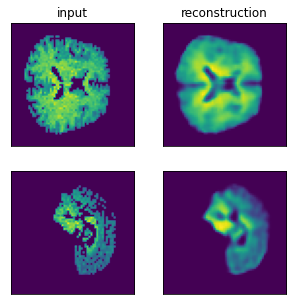

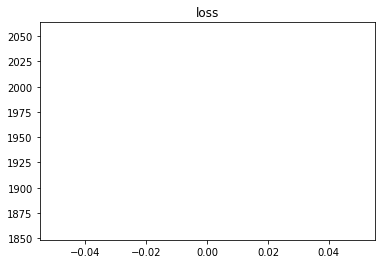

15/15 [==============================] - 5s 351ms/step - loss: 1949.9608
epoch time: 0:00:08.671225, elapsed time: 0:00:19.062320
15/15 [==============================] - 5s 354ms/step - loss: 1965.9933
epoch time: 0:00:21.605514, elapsed time: 0:00:40.668092
15/15 [==============================] - 5s 352ms/step - loss: 1959.2576
epoch time: 0:00:18.890129, elapsed time: 0:00:59.558473
15/15 [==============================] - 5s 352ms/step - loss: 1953.6656
epoch time: 0:00:21.824372, elapsed time: 0:01:21.383064
15/15 [==============================] - 5s 354ms/step - loss: 1942.1804
epoch time: 0:00:20.420109, elapsed time: 0:01:41.803403
15/15 [==============================] - 5s 352ms/step - loss: 1943.2292
epoch time: 0:00:29.610268, elapsed time: 0:02:11.413906
15/15 [==============================] - 5s 347ms/step - loss: 1953.6895
epoch time: 0:00:33.433242, elapsed time: 0:02:44.847411
15/15 [==============================] - 5s 351ms/step - loss: 1952.1089
epoch time: 0:00:

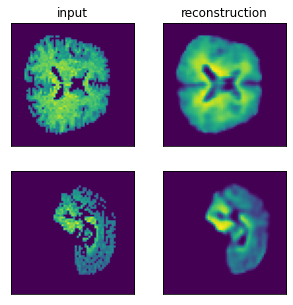

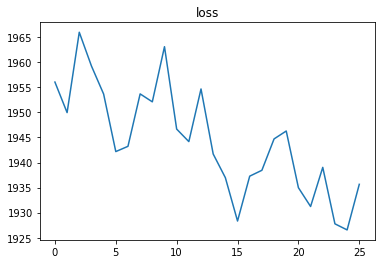

15/15 [==============================] - 5s 351ms/step - loss: 1929.7235
epoch time: 0:00:21.597052, elapsed time: 0:09:26.615054
15/15 [==============================] - 5s 354ms/step - loss: 1920.4382
epoch time: 0:00:28.027675, elapsed time: 0:09:54.642992
15/15 [==============================] - 5s 350ms/step - loss: 1926.1512
epoch time: 0:00:17.827117, elapsed time: 0:10:12.470741
15/15 [==============================] - 5s 351ms/step - loss: 1912.4570
epoch time: 0:00:08.773397, elapsed time: 0:10:21.244515
15/15 [==============================] - 5s 350ms/step - loss: 1926.4414
epoch time: 0:00:15.726657, elapsed time: 0:10:36.971358
15/15 [==============================] - 5s 353ms/step - loss: 1916.0599
epoch time: 0:00:28.120004, elapsed time: 0:11:05.091969
15/15 [==============================] - 5s 352ms/step - loss: 1925.2429
epoch time: 0:00:31.703471, elapsed time: 0:11:36.795705
15/15 [==============================] - 5s 355ms/step - loss: 1909.0426
epoch time: 0:00:

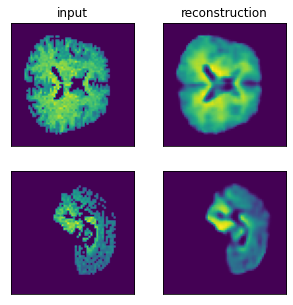

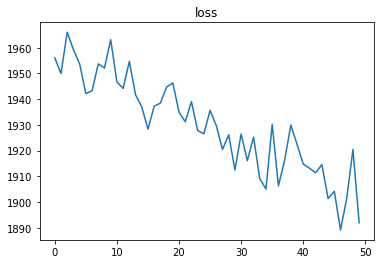

15/15 [==============================] - 5s 351ms/step - loss: 1908.0095
epoch time: 0:00:08.706953, elapsed time: 0:18:27.318891
15/15 [==============================] - 5s 349ms/step - loss: 1900.8322
epoch time: 0:00:16.204866, elapsed time: 0:18:43.524404
15/15 [==============================] - 5s 354ms/step - loss: 1908.2809
epoch time: 0:00:18.602339, elapsed time: 0:19:02.126990
15/15 [==============================] - 5s 343ms/step - loss: 1884.7424
epoch time: 0:00:34.156186, elapsed time: 0:19:36.283376
15/15 [==============================] - 5s 352ms/step - loss: 1900.8976
epoch time: 0:00:32.955766, elapsed time: 0:20:09.239418
15/15 [==============================] - 5s 350ms/step - loss: 1895.5645
epoch time: 0:00:09.133451, elapsed time: 0:20:18.373076
15/15 [==============================] - 5s 352ms/step - loss: 1878.9451
epoch time: 0:00:12.437760, elapsed time: 0:20:30.811016
15/15 [==============================] - 5s 354ms/step - loss: 1891.1752
epoch time: 0:00:

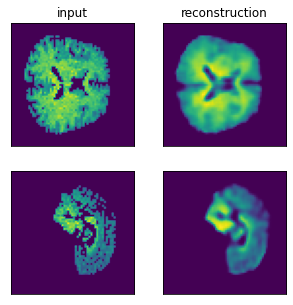

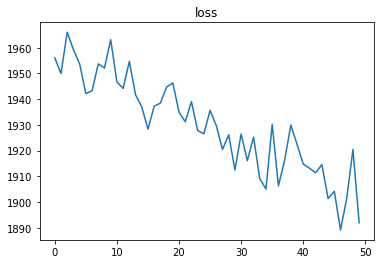

15/15 [==============================] - 5s 351ms/step - loss: 1885.7502
epoch time: 0:00:31.898605, elapsed time: 0:27:42.145443
15/15 [==============================] - 5s 354ms/step - loss: 1868.2571
epoch time: 0:00:25.598245, elapsed time: 0:28:07.744541
15/15 [==============================] - 5s 354ms/step - loss: 1878.2283
epoch time: 0:00:11.621418, elapsed time: 0:28:19.366255
15/15 [==============================] - 5s 354ms/step - loss: 1885.5494
epoch time: 0:00:17.203689, elapsed time: 0:28:36.570446
15/15 [==============================] - 5s 352ms/step - loss: 1866.1660
epoch time: 0:00:38.640792, elapsed time: 0:29:15.211512
15/15 [==============================] - 5s 356ms/step - loss: 1875.9191
epoch time: 0:00:43.988221, elapsed time: 0:29:59.200015
15/15 [==============================] - 5s 349ms/step - loss: 1868.9554
epoch time: 0:00:15.958545, elapsed time: 0:30:15.158848
15/15 [==============================] - 5s 351ms/step - loss: 1864.8827
epoch time: 0:00:

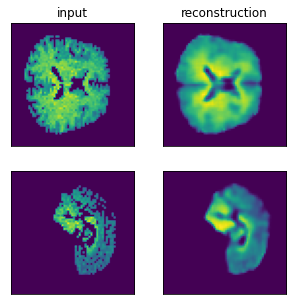

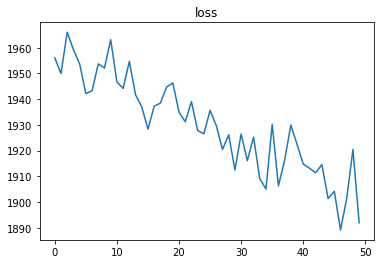

15/15 [==============================] - 5s 342ms/step - loss: 1853.3810
epoch time: 0:00:17.127258, elapsed time: 0:37:14.054507
15/15 [==============================] - 5s 353ms/step - loss: 1857.5878
epoch time: 0:00:14.671278, elapsed time: 0:37:28.725994
15/15 [==============================] - 5s 351ms/step - loss: 1860.8893
epoch time: 0:00:29.828505, elapsed time: 0:37:58.555005
15/15 [==============================] - 5s 353ms/step - loss: 1830.3070
epoch time: 0:00:32.917143, elapsed time: 0:38:31.472408
15/15 [==============================] - 5s 348ms/step - loss: 1862.0940
epoch time: 0:00:09.487961, elapsed time: 0:38:40.960650
15/15 [==============================] - 5s 349ms/step - loss: 1842.6431
epoch time: 0:00:18.356672, elapsed time: 0:38:59.317556
15/15 [==============================] - 5s 349ms/step - loss: 1836.1003
epoch time: 0:00:33.731103, elapsed time: 0:39:33.048982
15/15 [==============================] - 5s 355ms/step - loss: 1849.2596
epoch time: 0:00:

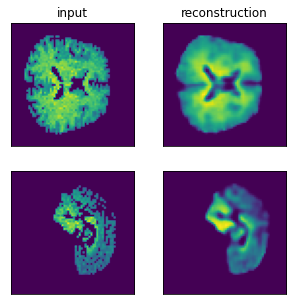

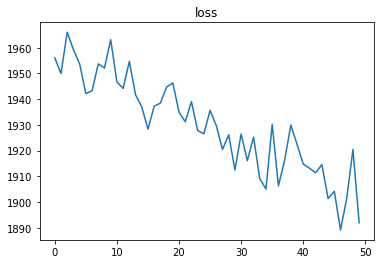

15/15 [==============================] - 5s 354ms/step - loss: 1822.2346
epoch time: 0:00:28.946865, elapsed time: 0:46:25.995033
15/15 [==============================] - 5s 353ms/step - loss: 1833.2269
epoch time: 0:00:16.550842, elapsed time: 0:46:42.546126
15/15 [==============================] - 5s 350ms/step - loss: 1837.7091
epoch time: 0:00:08.715900, elapsed time: 0:46:51.262540
15/15 [==============================] - 5s 353ms/step - loss: 1823.6388
epoch time: 0:00:19.030015, elapsed time: 0:47:10.292988
15/15 [==============================] - 5s 353ms/step - loss: 1822.7703
epoch time: 0:00:30.606562, elapsed time: 0:47:40.899809
15/15 [==============================] - 5s 354ms/step - loss: 1804.9409
epoch time: 0:00:37.767215, elapsed time: 0:48:18.667304
15/15 [==============================] - 5s 352ms/step - loss: 1830.9707
epoch time: 0:00:14.894614, elapsed time: 0:48:33.562575
15/15 [==============================] - 5s 343ms/step - loss: 1826.3042
epoch time: 0:00:

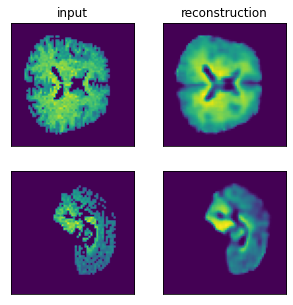

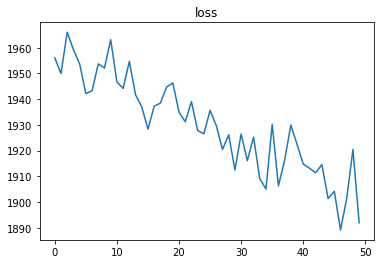

15/15 [==============================] - 5s 350ms/step - loss: 1814.6252
epoch time: 0:00:08.830369, elapsed time: 0:55:09.169535
15/15 [==============================] - 5s 349ms/step - loss: 1806.2792
epoch time: 0:00:17.053802, elapsed time: 0:55:26.223547
15/15 [==============================] - 5s 353ms/step - loss: 1812.7321
epoch time: 0:00:14.563009, elapsed time: 0:55:40.786844
15/15 [==============================] - 5s 348ms/step - loss: 1814.1919
epoch time: 0:00:32.657186, elapsed time: 0:56:13.444344
15/15 [==============================] - 5s 354ms/step - loss: 1800.6073
epoch time: 0:00:27.523262, elapsed time: 0:56:40.967866
15/15 [==============================] - 5s 350ms/step - loss: 1807.4712
epoch time: 0:00:08.865189, elapsed time: 0:56:49.833296
15/15 [==============================] - 5s 351ms/step - loss: 1804.4321
epoch time: 0:00:12.440853, elapsed time: 0:57:02.274600
15/15 [==============================] - 5s 352ms/step - loss: 1815.8380
epoch time: 0:00:

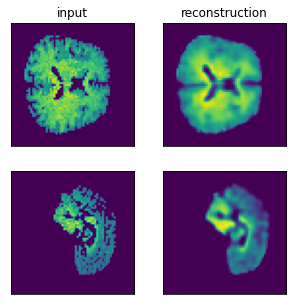

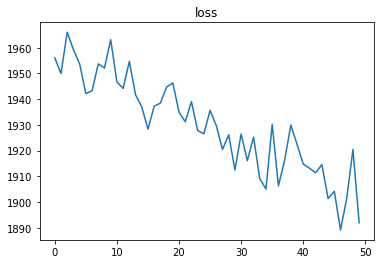

15/15 [==============================] - 5s 348ms/step - loss: 1798.6707
epoch time: 0:00:09.299989, elapsed time: 1:04:17.922924
15/15 [==============================] - 5s 347ms/step - loss: 1801.7173
epoch time: 0:00:21.797939, elapsed time: 1:04:39.721040
15/15 [==============================] - 5s 355ms/step - loss: 1793.9663
epoch time: 0:00:31.410399, elapsed time: 1:05:11.131666
15/15 [==============================] - 5s 352ms/step - loss: 1804.7649
epoch time: 0:00:17.523883, elapsed time: 1:05:28.655836
15/15 [==============================] - 5s 352ms/step - loss: 1810.1580
epoch time: 0:00:09.258324, elapsed time: 1:05:37.914336
15/15 [==============================] - 5s 342ms/step - loss: 1781.5508
epoch time: 0:00:16.360066, elapsed time: 1:05:54.274592
15/15 [==============================] - 5s 353ms/step - loss: 1797.8988
epoch time: 0:00:27.393399, elapsed time: 1:06:21.668225
15/15 [==============================] - 5s 357ms/step - loss: 1794.3628
epoch time: 0:00:

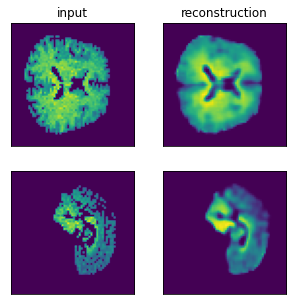

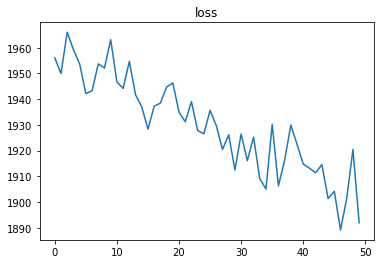

15/15 [==============================] - 5s 345ms/step - loss: 1782.9520
epoch time: 0:00:09.666969, elapsed time: 1:13:20.108724
15/15 [==============================] - 5s 348ms/step - loss: 1779.7737
epoch time: 0:00:17.601964, elapsed time: 1:13:37.710863
15/15 [==============================] - 5s 353ms/step - loss: 1777.4108
epoch time: 0:00:16.941043, elapsed time: 1:13:54.652133
15/15 [==============================] - 5s 354ms/step - loss: 1783.6051
epoch time: 0:00:33.869095, elapsed time: 1:14:28.521489
15/15 [==============================] - 5s 354ms/step - loss: 1777.4269
epoch time: 0:00:30.907768, elapsed time: 1:14:59.429625
15/15 [==============================] - 5s 350ms/step - loss: 1768.6697
epoch time: 0:00:09.424249, elapsed time: 1:15:08.854216
15/15 [==============================] - 5s 350ms/step - loss: 1756.8763
epoch time: 0:00:12.083066, elapsed time: 1:15:20.937452
15/15 [==============================] - 5s 348ms/step - loss: 1782.5671
epoch time: 0:00:

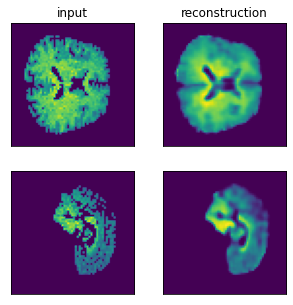

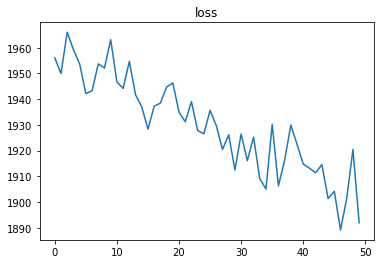

15/15 [==============================] - 5s 353ms/step - loss: 1769.7896
epoch time: 0:00:36.408589, elapsed time: 1:22:52.085531
15/15 [==============================] - 5s 354ms/step - loss: 1742.8148
epoch time: 0:00:33.593282, elapsed time: 1:23:25.679546
15/15 [==============================] - 5s 357ms/step - loss: 1785.4247
epoch time: 0:00:14.839850, elapsed time: 1:23:40.519662
15/15 [==============================] - 5s 342ms/step - loss: 1770.2723
epoch time: 0:00:09.328859, elapsed time: 1:23:49.849007
15/15 [==============================] - 5s 351ms/step - loss: 1752.8286
epoch time: 0:00:17.600429, elapsed time: 1:24:07.449612
15/15 [==============================] - 5s 351ms/step - loss: 1773.3319
epoch time: 0:00:28.398027, elapsed time: 1:24:35.847885
15/15 [==============================] - 5s 354ms/step - loss: 1767.4175
epoch time: 0:00:29.031969, elapsed time: 1:25:04.880158
15/15 [==============================] - 5s 355ms/step - loss: 1751.2604
epoch time: 0:00:

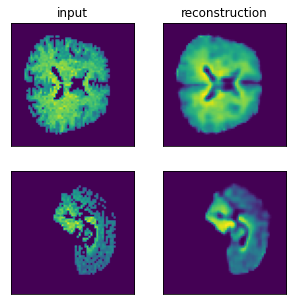

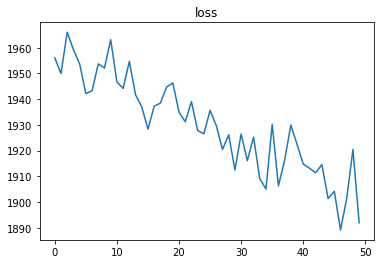

15/15 [==============================] - 5s 342ms/step - loss: 1745.1001
epoch time: 0:00:09.676374, elapsed time: 1:32:05.095813
15/15 [==============================] - 5s 351ms/step - loss: 1762.4017
epoch time: 0:00:16.681274, elapsed time: 1:32:21.777288
15/15 [==============================] - 5s 354ms/step - loss: 1757.9708
epoch time: 0:00:20.411391, elapsed time: 1:32:42.188944
15/15 [==============================] - 5s 357ms/step - loss: 1747.7378
epoch time: 0:00:35.856900, elapsed time: 1:33:18.046701
15/15 [==============================] - 5s 354ms/step - loss: 1760.9181
epoch time: 0:00:16.368855, elapsed time: 1:33:34.416399
15/15 [==============================] - 5s 353ms/step - loss: 1756.4156
epoch time: 0:00:09.247407, elapsed time: 1:33:43.663989
15/15 [==============================] - 5s 349ms/step - loss: 1745.6078
epoch time: 0:00:16.280737, elapsed time: 1:33:59.944922
15/15 [==============================] - 5s 351ms/step - loss: 1760.8937
epoch time: 0:00:

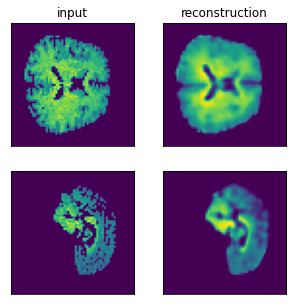

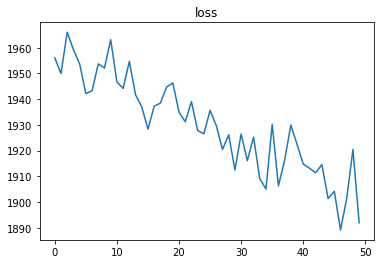

15/15 [==============================] - 5s 352ms/step - loss: 1743.2834
epoch time: 0:00:22.689965, elapsed time: 1:41:24.884647
15/15 [==============================] - 5s 350ms/step - loss: 1739.1206
epoch time: 0:00:09.862726, elapsed time: 1:41:34.747584
15/15 [==============================] - 5s 353ms/step - loss: 1744.7136
epoch time: 0:00:16.811848, elapsed time: 1:41:51.559744
15/15 [==============================] - 5s 354ms/step - loss: 1729.4325
epoch time: 0:00:13.539105, elapsed time: 1:42:05.099143
15/15 [==============================] - 5s 348ms/step - loss: 1743.7678
epoch time: 0:00:33.800764, elapsed time: 1:42:38.900173
15/15 [==============================] - 5s 346ms/step - loss: 1741.9924
epoch time: 0:00:31.169056, elapsed time: 1:43:10.069540
15/15 [==============================] - 5s 354ms/step - loss: 1740.2811
epoch time: 0:00:09.454403, elapsed time: 1:43:19.524219
15/15 [==============================] - 5s 349ms/step - loss: 1748.3196
epoch time: 0:00:

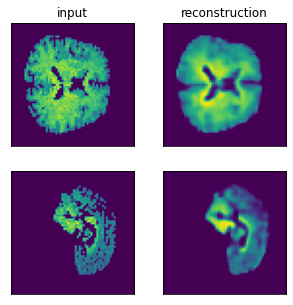

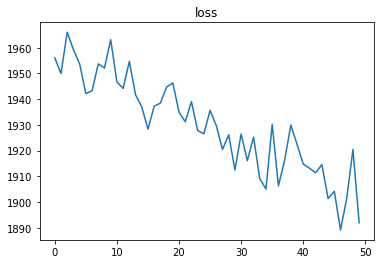

15/15 [==============================] - 5s 352ms/step - loss: 1742.7856
epoch time: 0:00:18.482490, elapsed time: 1:50:19.018745
15/15 [==============================] - 5s 353ms/step - loss: 1729.0938
epoch time: 0:00:35.680287, elapsed time: 1:50:54.699516
15/15 [==============================] - 5s 353ms/step - loss: 1719.4272
epoch time: 0:00:43.703974, elapsed time: 1:51:38.404335
15/15 [==============================] - 5s 353ms/step - loss: 1718.2052
epoch time: 0:00:15.653948, elapsed time: 1:51:54.058570
15/15 [==============================] - 5s 350ms/step - loss: 1739.3591
epoch time: 0:00:09.261385, elapsed time: 1:52:03.320136
15/15 [==============================] - 5s 345ms/step - loss: 1719.9198
epoch time: 0:00:17.634979, elapsed time: 1:52:20.955304
15/15 [==============================] - 5s 354ms/step - loss: 1738.3274
epoch time: 0:00:20.666115, elapsed time: 1:52:41.621747
15/15 [==============================] - 5s 354ms/step - loss: 1733.7096
epoch time: 0:00:

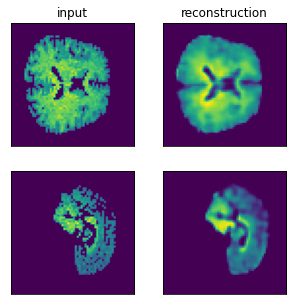

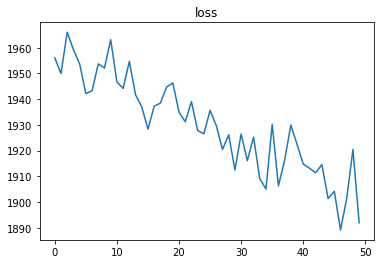

15/15 [==============================] - 5s 350ms/step - loss: 1715.2812
epoch time: 0:00:13.522565, elapsed time: 1:59:56.925996
15/15 [==============================] - 5s 352ms/step - loss: 1724.2642
epoch time: 0:00:17.854313, elapsed time: 2:00:14.780500
15/15 [==============================] - 5s 356ms/step - loss: 1716.3484
epoch time: 0:00:12.567359, elapsed time: 2:00:27.348180
15/15 [==============================] - 5s 352ms/step - loss: 1711.7573
epoch time: 0:00:31.441346, elapsed time: 2:00:58.789822
15/15 [==============================] - 5s 353ms/step - loss: 1716.6069
epoch time: 0:00:29.625647, elapsed time: 2:01:28.415820
15/15 [==============================] - 5s 352ms/step - loss: 1725.4015
epoch time: 0:00:08.795531, elapsed time: 2:01:37.211815
15/15 [==============================] - 5s 349ms/step - loss: 1726.3987
epoch time: 0:00:12.604240, elapsed time: 2:01:49.816273
15/15 [==============================] - 5s 356ms/step - loss: 1722.5442
epoch time: 0:00:

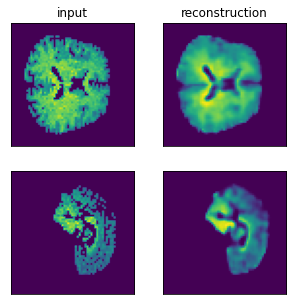

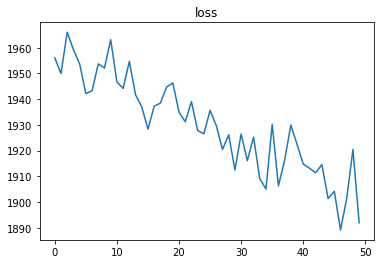

15/15 [==============================] - 5s 351ms/step - loss: 1719.2728
epoch time: 0:00:15.068442, elapsed time: 2:09:24.803392
15/15 [==============================] - 5s 349ms/step - loss: 1721.8511
epoch time: 0:00:09.562466, elapsed time: 2:09:34.366059
15/15 [==============================] - 5s 352ms/step - loss: 1709.7300
epoch time: 0:00:17.124150, elapsed time: 2:09:51.490454
15/15 [==============================] - 5s 356ms/step - loss: 1698.3187
epoch time: 0:00:27.481954, elapsed time: 2:10:18.972973
15/15 [==============================] - 5s 352ms/step - loss: 1714.4720
epoch time: 0:00:31.316849, elapsed time: 2:10:50.290636
15/15 [==============================] - 5s 357ms/step - loss: 1717.0077
epoch time: 0:00:15.536468, elapsed time: 2:11:05.827399
15/15 [==============================] - 5s 351ms/step - loss: 1706.1575
epoch time: 0:00:08.715411, elapsed time: 2:11:14.543083
15/15 [==============================] - 5s 351ms/step - loss: 1709.1948
epoch time: 0:00:

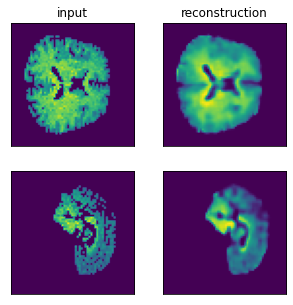

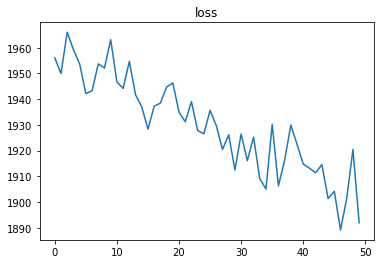

15/15 [==============================] - 5s 352ms/step - loss: 1718.7738
epoch time: 0:00:45.591509, elapsed time: 2:19:30.325091
15/15 [==============================] - 5s 355ms/step - loss: 1685.8724
epoch time: 0:00:13.977562, elapsed time: 2:19:44.302929
15/15 [==============================] - 5s 352ms/step - loss: 1701.0215
epoch time: 0:00:09.000968, elapsed time: 2:19:53.304098
15/15 [==============================] - 5s 350ms/step - loss: 1697.9701
epoch time: 0:00:17.818839, elapsed time: 2:20:11.123145
15/15 [==============================] - 5s 355ms/step - loss: 1701.4611
epoch time: 0:00:27.537241, elapsed time: 2:20:38.660635
15/15 [==============================] - 5s 352ms/step - loss: 1699.9241
epoch time: 0:00:36.262505, elapsed time: 2:21:14.924079
15/15 [==============================] - 5s 353ms/step - loss: 1696.5249
epoch time: 0:00:23.931012, elapsed time: 2:21:38.855708
15/15 [==============================] - 5s 349ms/step - loss: 1696.2531
epoch time: 0:00:

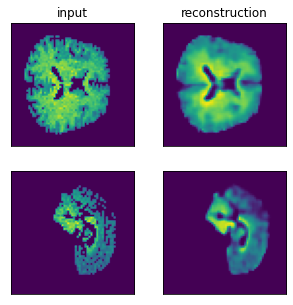

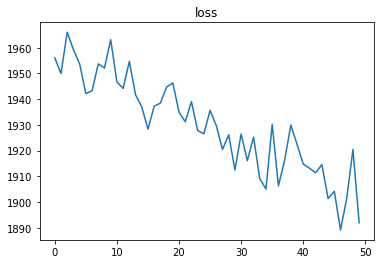

15/15 [==============================] - 5s 351ms/step - loss: 1690.4833
epoch time: 0:00:16.245429, elapsed time: 2:28:29.508052
15/15 [==============================] - 5s 357ms/step - loss: 1683.6810
epoch time: 0:00:14.634185, elapsed time: 2:28:44.142488
15/15 [==============================] - 5s 347ms/step - loss: 1686.0406
epoch time: 0:00:33.238582, elapsed time: 2:29:17.381315
15/15 [==============================] - 5s 353ms/step - loss: 1697.8684
epoch time: 0:00:32.294486, elapsed time: 2:29:49.676069
15/15 [==============================] - 5s 351ms/step - loss: 1693.2921
epoch time: 0:00:08.775094, elapsed time: 2:29:58.451362
15/15 [==============================] - 5s 351ms/step - loss: 1698.8890
epoch time: 0:00:14.745429, elapsed time: 2:30:13.196979
15/15 [==============================] - 5s 347ms/step - loss: 1690.4974
epoch time: 0:00:32.078638, elapsed time: 2:30:45.275877
15/15 [==============================] - 5s 355ms/step - loss: 1696.3759
epoch time: 0:00:

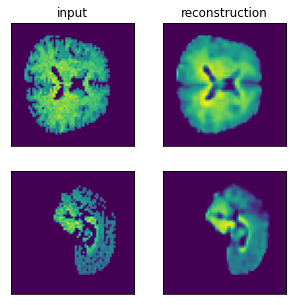

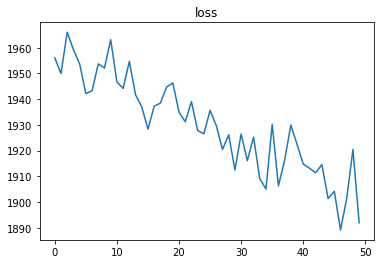

15/15 [==============================] - 5s 354ms/step - loss: 1686.7233
epoch time: 0:00:13.047463, elapsed time: 2:37:36.171201
15/15 [==============================] - 5s 353ms/step - loss: 1672.2201
epoch time: 0:00:09.242394, elapsed time: 2:37:45.413803
15/15 [==============================] - 5s 351ms/step - loss: 1687.8029
epoch time: 0:00:17.876035, elapsed time: 2:38:03.290063
15/15 [==============================] - 5s 352ms/step - loss: 1692.6853
epoch time: 0:00:20.587003, elapsed time: 2:38:23.877374
15/15 [==============================] - 5s 355ms/step - loss: 1685.3640
epoch time: 0:00:27.047713, elapsed time: 2:38:50.925390
15/15 [==============================] - 5s 347ms/step - loss: 1672.7114
epoch time: 0:00:41.713840, elapsed time: 2:39:32.639555
15/15 [==============================] - 5s 354ms/step - loss: 1691.8860
epoch time: 0:00:15.257443, elapsed time: 2:39:47.897251
15/15 [==============================] - 5s 350ms/step - loss: 1683.2970
epoch time: 0:00:

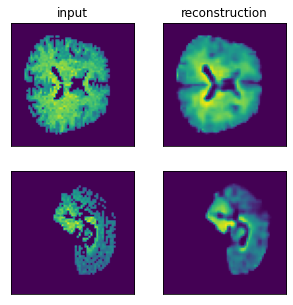

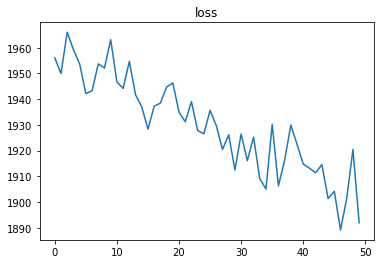

15/15 [==============================] - 5s 348ms/step - loss: 1673.2632
epoch time: 0:00:15.682521, elapsed time: 2:47:12.962769
15/15 [==============================] - 5s 352ms/step - loss: 1689.5580
epoch time: 0:00:14.635053, elapsed time: 2:47:27.598073
15/15 [==============================] - 5s 355ms/step - loss: 1666.6034
epoch time: 0:00:34.616376, elapsed time: 2:48:02.214913
15/15 [==============================] - 5s 355ms/step - loss: 1686.8281
epoch time: 0:00:43.021350, elapsed time: 2:48:45.236588
15/15 [==============================] - 5s 354ms/step - loss: 1684.2070
epoch time: 0:00:14.847672, elapsed time: 2:49:00.084633
15/15 [==============================] - 5s 350ms/step - loss: 1677.8645
epoch time: 0:00:08.875567, elapsed time: 2:49:08.960404
15/15 [==============================] - 5s 350ms/step - loss: 1676.7649
epoch time: 0:00:18.160343, elapsed time: 2:49:27.121295
15/15 [==============================] - 5s 353ms/step - loss: 1674.9308
epoch time: 0:00:

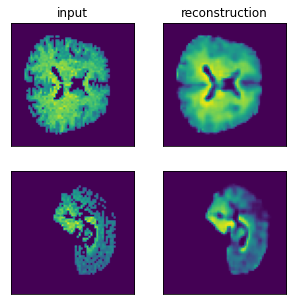

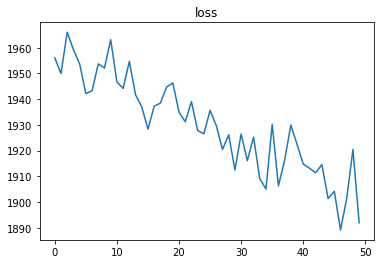

15/15 [==============================] - 5s 350ms/step - loss: 1674.0840
epoch time: 0:00:09.378953, elapsed time: 2:56:16.020075
15/15 [==============================] - 5s 345ms/step - loss: 1665.7372
epoch time: 0:00:19.471884, elapsed time: 2:56:35.492120
15/15 [==============================] - 5s 351ms/step - loss: 1679.1250
epoch time: 0:00:22.573796, elapsed time: 2:56:58.066148
15/15 [==============================] - 5s 349ms/step - loss: 1648.9789
epoch time: 0:00:31.675800, elapsed time: 2:57:29.742246
15/15 [==============================] - 5s 354ms/step - loss: 1674.9387
epoch time: 0:00:15.447548, elapsed time: 2:57:45.190579
15/15 [==============================] - 5s 350ms/step - loss: 1658.7075
epoch time: 0:00:08.797579, elapsed time: 2:57:53.988605
15/15 [==============================] - 5s 350ms/step - loss: 1675.5500
epoch time: 0:00:23.337721, elapsed time: 2:58:17.326591
15/15 [==============================] - 5s 353ms/step - loss: 1662.2877
epoch time: 0:00:

In [ ]:
t0 = now()
print(f'started: {now()}')
loss = list()
for i in range(500):
    e0 = now()
    hist = cvae.fit([DX_subs,TD_subs[0:456,:,:,:]],epochs=1)

    loss.append(hist.history['loss']);loss = loss[0:min((50,len(loss)))]

    cvae.save_weights('../tf_outputs/3D_CCVAE_Weights/Nov23')
    print(f"epoch time: {now()-e0}, elapsed time: {now()-t0}")
    if np.mod(i,25)==0:
        #plot_state_ccvae(latent_dim)
        plot_recon()
        plt.show()
        plt.plot(loss);plt.title('loss')
        plt.show()
print(f'done in: {now()-t0}')

In [ ]:
len(loss)

600

50